In [10]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [11]:
now = datetime.datetime.now()

In [2]:
train_df = pd.read_csv('dataset/train_01.csv')
test_df = pd.read_csv('dataset/test_01.csv')

In [3]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns='id')

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18
                                                   )

# RFC

In [5]:
def objective(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)
    
    param_rfc ={      
        'n_estimators': trial.suggest_int('n_estimators', 800, 1500),
        'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5),
        'random_state': 18,
        'n_jobs': 2
    }
    
    rfc = RandomForestClassifier(**param_rfc)
    scores = cross_validate(rfc, x, y, cv=skf)
    return scores['test_score'].mean()

In [6]:
%%time

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective, n_trials=100, n_jobs=4)
print(study_rfc.best_params)
print(study_rfc.best_value)
rfc_best_params = study_rfc.best_params

[I 2020-08-08 19:45:41,393] Finished trial#0 resulted in value: 0.929040590405904. Current best value is 0.929040590405904 with parameters: {'n_estimators': 895, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}.
[I 2020-08-08 19:45:54,240] Finished trial#1 resulted in value: 0.9289667896678967. Current best value is 0.929040590405904 with parameters: {'n_estimators': 895, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}.
[I 2020-08-08 19:45:55,716] Finished trial#2 resulted in value: 0.9289667896678967. Current best value is 0.929040590405904 with parameters: {'n_estimators': 895, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1}.
[I 2020-08-08 19:45:57,112] Finished trial#3 resulted in value: 0.9290774907749079. Current best value is 0.9290774907749079 with parameters: {'n_estimators': 1191, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf':

{'n_estimators': 1499, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 5}
0.9298154981549815
CPU times: user 1h 50min 24s, sys: 7min 3s, total: 1h 57min 27s
Wall time: 29min 9s


In [7]:
rfc = RandomForestClassifier(**rfc_best_params)
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5,
                       min_samples_split=9, n_estimators=1499)

In [8]:
train_score_rfc = rfc.score(x_train, y_train)
test_score_rfc = rfc.score(x_test, y_test)

rfc_p = rfc.predict(x_test)

acc_rfc = accuracy_score(rfc_p, y_test)
auc_rfc = roc_auc_score(rfc_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rfc, test_score_rfc))
print('acc:{}, auc:{}'.format(acc_rfc, auc_rfc))

train score:0.9312071692145493, test_score:0.9303813038130382
acc:0.9303813038130382, auc:0.9277173913043478


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


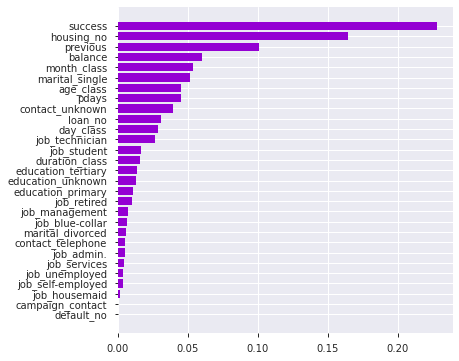

In [9]:
features = x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [12]:
rfc_name = 'models/rfc_' + now.strftime('%d_%H%M') + '.sav'
pickle.dump(rfc, open(rfc_name, 'wb'))

# XGB

In [15]:
xgb = xgb.XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [16]:
train_score_xgb = xgb.score(x_train, y_train)
test_score_xgb = xgb.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))

train score:0.948339483394834, test_score:0.9263222632226322


# LGB

In [17]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

params_lgb = {
    'objective': 'binary',
    'metric':'auc',
    'num_iterations':1000,
    'eary_stopping': 50,
}

lgb = lgb.train(params_lgb, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

/home/awax2/miniconda3/envs/lab/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's auc: 0.763361
[200]	valid_0's auc: 0.754556
[300]	valid_0's auc: 0.745252
[400]	valid_0's auc: 0.736765
[500]	valid_0's auc: 0.732291
[600]	valid_0's auc: 0.727375
[700]	valid_0's auc: 0.722609
[800]	valid_0's auc: 0.720291
[900]	valid_0's auc: 0.716577
[1000]	valid_0's auc: 0.712123


# CB

In [18]:
params_cab = {
    'iterations':1000,
    'custom_loss':['Accuracy'],
    'early_stopping_rounds':50,
}

In [19]:
cab = CatBoostClassifier(**params_cab)

cab.fit(x_train, y_train)

Learning rate set to 0.036197
0:	learn: 0.6523841	total: 75.7ms	remaining: 1m 15s
1:	learn: 0.6157785	total: 83.4ms	remaining: 41.6s
2:	learn: 0.5822001	total: 91.2ms	remaining: 30.3s
3:	learn: 0.5516569	total: 101ms	remaining: 25.1s
4:	learn: 0.5241587	total: 111ms	remaining: 22s
5:	learn: 0.4981506	total: 121ms	remaining: 20s
6:	learn: 0.4732370	total: 128ms	remaining: 18.2s
7:	learn: 0.4524919	total: 136ms	remaining: 16.9s
8:	learn: 0.4329606	total: 144ms	remaining: 15.9s
9:	learn: 0.4158419	total: 151ms	remaining: 14.9s
10:	learn: 0.4007643	total: 158ms	remaining: 14.2s
11:	learn: 0.3866430	total: 164ms	remaining: 13.5s
12:	learn: 0.3752579	total: 172ms	remaining: 13.1s
13:	learn: 0.3637828	total: 178ms	remaining: 12.5s
14:	learn: 0.3532122	total: 185ms	remaining: 12.2s
15:	learn: 0.3419082	total: 195ms	remaining: 12s
16:	learn: 0.3320476	total: 202ms	remaining: 11.7s
17:	learn: 0.3230439	total: 210ms	remaining: 11.5s
18:	learn: 0.3158758	total: 217ms	remaining: 11.2s
19:	learn: 0.

In [20]:
train_score_cab = cab.score(x_train, y_train)
test_score_cab = cab.score(x_test, y_test)

print('train score:{}, test_score:{}'.format(train_score_cab, test_score_cab))

train score:0.9430152872957301, test_score:0.9281672816728167


## submit

In [21]:
pred_rfc = rfc.predict(test_df)
pred_xgb = xgb.predict(test_df)
pred_lgb = lgb.predict(test_df)
pred_cab = cab.predict(test_df)

In [22]:
pred = pd.DataFrame({
    'RandomForest': pred_rfc,
    'XGBoost': pred_xgb,
    'LigntGBM': pred_lgb,
    'CatBoost': pred_cab
})

pred['sum'] = pred.sum(axis=1)
pred['pred'] = [i / 4.0 for i in pred['sum']]
pred.head()

,RandomForest,XGBoost,LigntGBM,CatBoost,sum,pred
0,1,1,0.993335,1,3.993335,0.998334
1,0,0,0.003490,0,0.003490,0.000873
2,0,0,0.011443,0,0.011443,0.002861
3,0,0,0.004827,0,0.004827,0.001207
4,0,0,0.025006,0,0.025006,0.006252


In [23]:
submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})


now = datetime.datetime.now()
file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [25]:
ID.head()

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64